In [2]:
import wrf
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import glob
import pickle as pkl
import scipy
import statsmodels.api as sm
import matplotlib.dates as md
%matplotlib inline

## WRF-Chem simulation results at IAG Station

In [3]:
path = '../3_Results/rain/'
paths = !ls {path+'*.pickle'}
paths

['../3_Results/rain/rain_2018-09_current.pickle',
 '../3_Results/rain/rain_2018-10_current.pickle',
 '../3_Results/rain/rain_2030-09_rcp4_5.pickle',
 '../3_Results/rain/rain_2030-09_rcp8_5.pickle',
 '../3_Results/rain/rain_2030-10_rcp4_5.pickle',
 '../3_Results/rain/rain_2030-10_rcp8_5.pickle']

In [4]:
rain = {}
files = ['sep2018','oct2018','rcp4.5sep2030','rcp8.5sep2030','rcp4.5oct2030','rcp8.5oct2030']
for p, f in zip(paths, files):
    rain[f] = pkl.load(open(p, "rb"))

In [5]:
rain

{'sep2018': {'Americana':                    date      rainc    rainnc  code       name  \
  0   2018-09-01 00:00:00   0.000000  0.000000   290  Americana   
  1   2018-09-01 01:00:00   0.000000  0.000000   290  Americana   
  2   2018-09-01 02:00:00   0.000000  0.000000   290  Americana   
  3   2018-09-01 03:00:00   0.000000  0.000000   290  Americana   
  4   2018-09-01 04:00:00   0.000000  0.000000   290  Americana   
  ..                  ...        ...       ...   ...        ...   
  715 2018-09-30 19:00:00  62.935360  5.438815   290  Americana   
  716 2018-09-30 20:00:00  62.935360  5.443727   290  Americana   
  717 2018-09-30 21:00:00  62.964432  5.449878   290  Americana   
  718 2018-09-30 22:00:00  62.964432  5.450297   290  Americana   
  719 2018-09-30 23:00:00  62.964432  5.450297   290  Americana   
  
                     local_date  
  0   2018-08-31 21:00:00-03:00  
  1   2018-08-31 22:00:00-03:00  
  2   2018-08-31 23:00:00-03:00  
  3   2018-09-01 00:00:00-03:00  

We analise rain simulations at IAG station

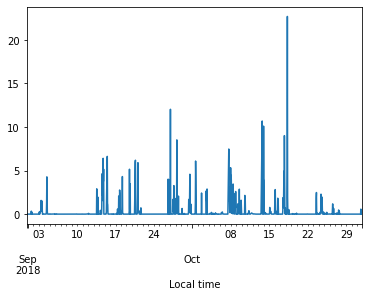

In [6]:
IAG_mod = pd.concat([rain['sep2018']['IAG'],rain['oct2018']['IAG']]).set_index('local_date')[['rainc','rainnc']]
IAG_mod['total_accum'] = IAG_mod.rainc + IAG_mod.rainnc
prev_total = [IAG_mod.rainc[i]+IAG_mod.rainnc[i] if i == 0 else 
              IAG_mod.rainc[i-1]+IAG_mod.rainnc[i-1] for i in range(len(IAG_mod.index))]
IAG_mod['prev_total'] = prev_total
IAG_mod['rr'] = IAG_mod.total_accum - IAG_mod.prev_total
IAG_mod.loc[IAG_mod.rr < 0] = 0
IAG_mod.rr.plot(xlabel='Local time');

In [7]:
IAG_mod.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1464 entries, 2018-08-31 21:00:00-03:00 to 2018-10-31 20:00:00-03:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   rainc        1464 non-null   float32
 1   rainnc       1464 non-null   float32
 2   total_accum  1464 non-null   float32
 3   prev_total   1464 non-null   float64
 4   rr           1464 non-null   float64
dtypes: float32(3), float64(2)
memory usage: 51.5 KB


In [8]:
mod_sep18 = pd.read_csv('../3_Results/Y2018/wrfout_exp10/sep18/0_FIN_d02.csv')
mod_sep18.loc[:,'date'] = pd.to_datetime(mod_sep18['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize("UTC")
mod_sep18.loc[:,'local_date']=mod_sep18['date'].dt.tz_convert('America/Sao_Paulo')
mod_sep18.drop('date', axis=1, inplace=True)
mod_sep18.set_index('local_date', inplace=True)
#mod_sep18 = mod_sep18.loc['2018-09':'2018-09-30 23:00',:]

mod_oct18 = pd.read_csv('../3_Results/Y2018/wrfout_exp10/oct18/0_FIN_d02.csv')
mod_oct18.loc[:,'date'] = pd.to_datetime(mod_oct18['date'], format='%Y-%m-%d %H:%M:%S').dt.tz_localize("UTC")
mod_oct18.loc[:,'local_date']=mod_oct18['date'].dt.tz_convert('America/Sao_Paulo')
mod_oct18.drop('date', axis=1, inplace=True)
mod_oct18.set_index('local_date', inplace=True)

columns = list(mod_sep18.columns)
mod_iag = pd.merge(mod_sep18,mod_oct18, left_index=True, right_index=True, how='outer', on=columns)
#mod_iag.set_index('local_date', inplace=True)
mod_iag

,tc,rh,ws,wd,o3,no,no2,co,code,name
local_date,,,,,,,,,,
2018-08-31 21:00:00-03:00,23.654083,48.028713,1.297267,125.841705,5.412841,13.644875,116.434235,0.427695,0,IAG
2018-08-31 22:00:00-03:00,22.902070,49.138756,1.740304,74.174240,0.006316,58.783443,111.630710,0.549718,0,IAG
2018-08-31 23:00:00-03:00,22.028717,51.901380,1.670710,55.931034,0.000009,104.209435,92.848280,0.608554,0,IAG
2018-09-01 00:00:00-03:00,21.286469,54.474434,1.567962,49.683704,0.000044,104.353710,82.101430,0.591731,0,IAG
2018-09-01 01:00:00-03:00,20.802979,55.451843,1.697465,52.614380,0.001931,84.191310,78.366440,0.510112,0,IAG
...,...,...,...,...,...,...,...,...,...,...
2018-10-31 16:00:00-03:00,27.615875,59.799286,3.672673,159.212370,129.863980,3.195609,32.146630,0.212109,0,IAG
2018-10-31 17:00:00-03:00,25.768036,65.673520,4.096571,165.377040,123.254060,2.027905,37.875220,0.276373,0,IAG
2018-10-31 18:00:00-03:00,23.663055,75.430200,3.355664,177.115040,118.528800,0.702324,41.202220,0.277683,0,IAG


In [9]:
iag_mod = pd.merge(mod_iag, IAG_mod, 
         right_index=True, left_index=True).drop(['rainc', 'rainnc',
                                                  'total_accum', 'prev_total',
                                                  'o3','no','no2','co','code','name'], axis=1)
iag_mod

,tc,rh,ws,wd,rr
local_date,,,,,
2018-08-31 21:00:00-03:00,23.654083,48.028713,1.297267,125.841705,0.000000
2018-08-31 22:00:00-03:00,22.902070,49.138756,1.740304,74.174240,0.000000
2018-08-31 23:00:00-03:00,22.028717,51.901380,1.670710,55.931034,0.000000
2018-09-01 00:00:00-03:00,21.286469,54.474434,1.567962,49.683704,0.000000
2018-09-01 01:00:00-03:00,20.802979,55.451843,1.697465,52.614380,0.000000
...,...,...,...,...,...
2018-10-31 16:00:00-03:00,27.615875,59.799286,3.672673,159.212370,0.572249
2018-10-31 17:00:00-03:00,25.768036,65.673520,4.096571,165.377040,0.000000
2018-10-31 18:00:00-03:00,23.663055,75.430200,3.355664,177.115040,0.000000


## Observations from IAG station (September-October, 2018)

We open observations from IAG met station

In [10]:
iag_obs = pkl.load(open('../2_Met/IAG/iag_met.pkl',"rb")).drop(['name','code'],axis=1)
iag_obs

,ws,wd,tc,rh,pres,rr,sun,cc
local_date,,,,,,,,
2018-09-01 00:00:00-03:00,0.56,315.0,17.1,68,924.920435,0.0,0.0,NaN
2018-09-01 01:00:00-03:00,0.56,315.0,16.5,70,924.951833,0.0,0.0,NaN
2018-09-01 02:00:00-03:00,0.28,315.0,16.0,83,924.849909,0.0,0.0,NaN
2018-09-01 03:00:00-03:00,0.00,315.0,15.9,87,924.481341,0.0,0.0,NaN
2018-09-01 04:00:00-03:00,0.28,315.0,15.9,88,924.512739,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...
2018-10-31 19:00:00-03:00,1.39,90.0,18.4,95,924.874335,0.1,0.0,10.0
2018-10-31 20:00:00-03:00,0.28,135.0,18.2,96,926.085304,0.0,0.0,10.0
2018-10-31 21:00:00-03:00,0.83,45.0,18.4,95,925.967609,0.0,0.0,10.0


In [11]:
met_iag = iag_obs.groupby(iag_obs.index.strftime('%Y-%m-%d')).agg({'rr':'sum','cc':'mean'})
met_iag.index = pd.to_datetime(met_iag.index, format='%Y-%m-%d %H:%M:%S')
met_iag

,rr,cc
local_date,,
2018-09-01,0.0,4.058824
2018-09-02,0.1,5.833333
2018-09-03,1.6,7.222222
2018-09-04,3.0,8.777778
2018-09-05,1.5,6.833333
...,...,...
2018-10-27,11.6,8.777778
2018-10-28,1.5,8.833333
2018-10-29,0.0,10.000000


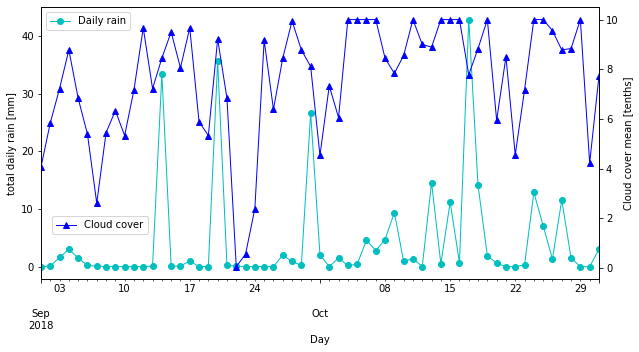

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
met_iag.plot(ax=ax, secondary_y='cc',style=['-oc','-^b'], lw=1,legend=True, ylabel='total daily rain [mm]')
plt.ylabel('Cloud cover mean [tenths]')
ax.legend(['Daily rain'],loc=2)
plt.legend(['Cloud cover'],bbox_to_anchor=(0.2, 0.25))
ax.set_xlabel('Day')
fig.savefig('../4_Draft_Report/Dissertation/fig/rain_cc_IAG.pdf', bbox_inches='tight', facecolor='w')

## Prediction vs Observation

In [13]:
iag_met = pd.merge(iag_obs, iag_mod, left_index=True, right_index=True, suffixes=('_obs', '_mod'))
iag_met.loc[:,'station'] = 'IAG'
iag_met.loc[:,'code'] = 0
iag_met.loc[:,'type'] = 'Forest preservation'
iag_met

,ws_obs,wd_obs,tc_obs,rh_obs,pres,rr_obs,sun,cc,tc_mod,rh_mod,ws_mod,wd_mod,rr_mod,station,code,type
local_date,,,,,,,,,,,,,,,,
2018-09-01 00:00:00-03:00,0.56,315.0,17.1,68,924.920435,0.0,0.0,NaN,21.286469,54.474434,1.567962,49.683704,0.000000,IAG,0,Forest preservation
2018-09-01 01:00:00-03:00,0.56,315.0,16.5,70,924.951833,0.0,0.0,NaN,20.802979,55.451843,1.697465,52.614380,0.000000,IAG,0,Forest preservation
2018-09-01 02:00:00-03:00,0.28,315.0,16.0,83,924.849909,0.0,0.0,NaN,20.404633,56.681030,1.868833,46.147686,0.000000,IAG,0,Forest preservation
2018-09-01 03:00:00-03:00,0.00,315.0,15.9,87,924.481341,0.0,0.0,NaN,19.833832,58.431877,1.637773,52.347534,0.000000,IAG,0,Forest preservation
2018-09-01 04:00:00-03:00,0.28,315.0,15.9,88,924.512739,0.0,0.0,NaN,19.491058,58.999493,1.754451,63.093990,0.000000,IAG,0,Forest preservation
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-31 16:00:00-03:00,4.72,180.0,19.1,92,925.857677,0.9,0.0,7.0,27.615875,59.799286,3.672673,159.212370,0.572249,IAG,0,Forest preservation
2018-10-31 17:00:00-03:00,3.33,180.0,18.8,93,926.556041,0.5,0.0,10.0,25.768036,65.673520,4.096571,165.377040,0.000000,IAG,0,Forest preservation
2018-10-31 18:00:00-03:00,1.39,202.5,18.5,95,926.601593,1.5,0.0,10.0,23.663055,75.430200,3.355664,177.115040,0.000000,IAG,0,Forest preservation


In [14]:
iag_met.to_csv('data/iag_met_obs_mod.csv')

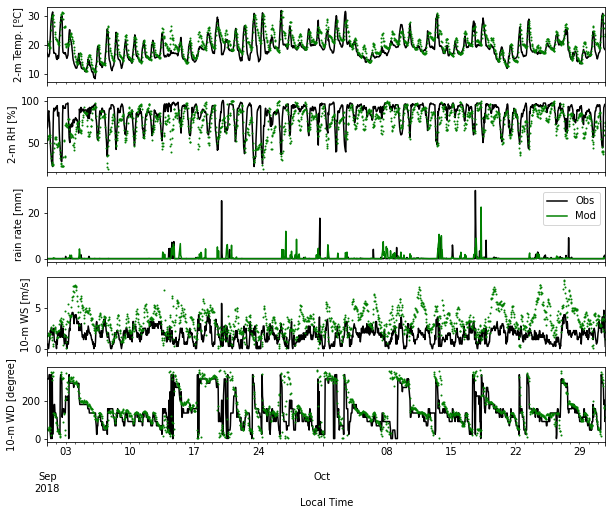

In [15]:
fig, ax= plt.subplots(5, figsize=(10,8),sharex=True)
iag_met.plot(y=['tc_obs','tc_mod'], ax=ax[0], style=['-k','.g'],ylabel='2-m Temp. [ºC]', legend = False,
            markersize = 2)
iag_met.plot(y=['rh_obs','rh_mod'], ax=ax[1], style=['-k','.g'],ylabel='2-m RH [%]',legend = False,
            markersize = 2)
iag_met.plot(y=['rr_obs','rr_mod'], ax=ax[2], style=['-k','-g'], ylabel='rain rate [mm]',legend = False,
            markersize = 2)
iag_met.plot(y=['ws_obs','ws_mod'], ax=ax[3], style=['-k','.g'],ylabel='10-m WS [m/s]',legend = False,
            markersize = 2)
iag_met.plot(y=['wd_obs','wd_mod'], ax=ax[4], style=['-k','.g'],ylabel='10-m WD [degree]',legend = False,
            markersize = 2)
ax[4].set_xlabel('Local Time')
ax[2].legend(['Obs', 'Mod'])
fig.savefig('../4_Draft_Report/Dissertation/fig/met_IAG_comparison.pdf', bbox_inches='tight', facecolor='w')

<AxesSubplot:xlabel='local_date'>

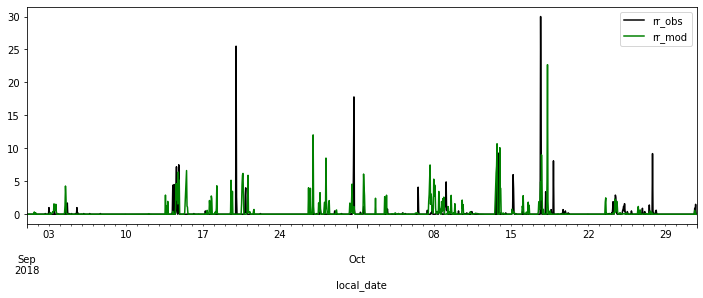

In [16]:
iag_met.plot(y=['rr_obs','rr_mod'], figsize=(12,4), color='kg')

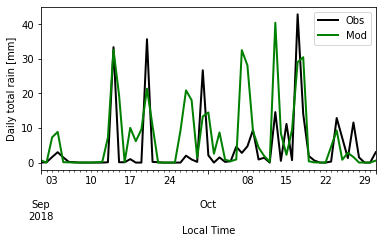

In [17]:
fig, ax = plt.subplots(figsize=(6,3))
iag_met.resample('D').sum().plot(y=['rr_obs','rr_mod'], style=['k','g'], ax=ax, lw=2)
ax.set_xlabel('Local Time')
ax.set_ylabel('Daily total rain [mm]')
ax.legend(['Obs','Mod'])
fig.savefig('../4_Draft_Report/Dissertation/fig/iag_daily_rain.pdf',bbox_inches='tight', facecolor='w')

## Statistical Evaluation

In [18]:
import mod_stats as ms

The `mod_stats` script was built by Mario Gavidia and with few changes done by me. Here you see the follow functions:
```python
* aq_stats(data, polls=['o3', 'no', 'no2', 'co', 'tc', 'rh'])
* met_stats(data,mets=['tc','rh','ws','wd'])
* r_pearson_sig(n, r, alpha, deg_free = n-2)
* r_pearson_confidence_interval(n, r, alpha)
```

Furthermore, statistical benchmarks from Monk et al. (2019) were used to evaluate meteorology results for complex terrain:

Parameter        | Criteria (complex terrain)
----------       | --------
Temperature      | MB  $\leq\pm$ 1 K
                 | MAGE $\leq$ 3.0
                 | IOA $\geq$ 0.8
Wind speed       | RMSE $\leq$ 2.5
                 | MB   $\leq \pm$ 1.5 ms$^{-1}$
                 | IOA $\geq$ 0.6
Wind direction   | MB < $\pm$ 10º
                 | ME $\leq$ 55º
Relative Humidity| MB < $\pm$10%
                 | MAGE < 20%
                 | IOA $\geq$ 0.6

### IAG station

In [19]:
stats_df1 = ms.met_stats(iag_met,mets=['tc', 'rh','rr','ws','wd']).round(2)
stats_df1

,n,MB,MAGE,RMSE,IOA,r,Mm,Om,Msd,Osd
tc,1461,1.56,1.97,2.66,0.89,0.85,20.32,18.76,3.96,3.89
rh,1461,-9.00,11.16,14.66,0.78,0.71,74.29,83.30,15.67,14.46
rr,1461,0.13,0.42,1.72,0.23,0.11,0.30,0.18,1.20,1.35
ws,1461,1.69,1.84,2.22,0.43,0.37,3.37,1.69,1.50,0.91
wd,1461,5.03,32.58,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
print(stats_df1.to_latex(caption='Statistical results for meteorological parameters for Sep-Oct 2018 (IAG/USP station)',
                            label='tab:stats_iag'),
      file=open('../4_Draft_Report/Dissertation/table/stats_iag.tex','w'))

In [20]:
para = ['tc','rh','ws','rr']
df_1 = pd.DataFrame(index=['t-statistic', 't critical'])

for p in para:
    df_1[p] = ms.r_pearson_sig(n=stats_df1.loc[p,'n'],
                             r=stats_df1.loc[p,'r'],
                             deg_free=stats_df1.loc[p,'n']-2,
                             alpha=0.05)
df_1.round(2)

Significant linear relationship
Significant linear relationship
Significant linear relationship
Significant linear relationship


,tc,rh,ws,rr
t-statistic,61.63,38.51,15.21,4.23
t critical,1.96,1.96,1.96,1.96


In [47]:
print(df_1.round(2).to_latex(caption='Correlation t-test values by meteorological parameter for Sep-Oct 2018(IAG/USP station))',
                            label='tab: r_sign_iag'),
      file=open('../4_Draft_Report/Dissertation/table/r_sign_iag.tex','a'))

In [120]:
df_2 = pd.DataFrame(index=['r (lower)', 'r (upper)'])
for p in para:
    df_2[p] = ms.r_pearson_confidence_interval(n=stats_df1.loc[p,'n'], r=stats_df1.loc[p,'r'], alpha=0.05)
df_2.round(2)

,tc,rh,ws,rr
r (lower),0.84,0.68,0.32,0.06
r (upper),0.86,0.73,0.41,0.16


In [127]:
pd.merge(df_1,df_2, left_index=True, right_index=True, how='outer', on=['tc','rh','ws','rr'])

,tc,rh,ws,rr
r (lower),0.835120,0.683607,0.324880,0.059048
r (upper),0.863637,0.734539,0.413440,0.160380
t_cal,61.633251,38.511368,15.212438,4.227307
t_cri,1.961591,1.961591,1.961591,1.961591


# WRF-Chem results at CETESB stations + IAG station

In [21]:
filename = 'data/alldata_Sep18.pkl'
sep18 = pd.read_pickle(filename).set_index('local_date')
sep18

,tc_obs,rh_obs,sr,ws_obs,wd_obs,code,station,type,o3_obs,no_obs,...,nox_obs,tc_mod,rh_mod,ws_mod,wd_mod,o3_mod,no_mod,no2_mod,co_mod,nox_mod
local_date,,,,,,,,,,,,,,,,,,,,,
2018-09-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,NaN,NaN,...,NaN,23.298310,44.076140,2.693815,7.026842,27.682203,2.239252,49.752037,0.219564,51.991289
2018-09-01 01:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,22.410126,48.023920,2.216470,6.119945,21.225119,3.053056,51.420452,0.214394,54.473508
2018-09-01 02:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,21.407288,52.332270,1.305349,50.996380,4.005378,18.056173,67.957460,0.276220,86.013633
2018-09-01 03:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,20.983826,53.653320,1.469841,60.283295,3.622969,19.596310,67.286620,0.272637,86.882930
2018-09-01 04:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,21.093628,51.141346,2.060035,22.507019,9.613392,9.917302,61.067800,0.232560,70.985102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-09-30 20:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,23.879486,76.376770,1.493314,51.072464,18.262321,4.077520,70.774870,0.264686,74.852390
2018-09-30 21:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,21.578583,85.585650,3.020036,35.262924,57.602943,0.799135,35.478043,0.178308,36.277178
2018-09-30 22:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,20.903015,90.767710,2.710160,39.816574,43.506443,1.280130,41.560406,0.192826,42.840536


In [22]:
filename = 'data/alldata_Oct18.pkl'
oct18 = pd.read_pickle(filename).set_index('local_date')
oct18

,tc_obs,rh_obs,sr,ws_obs,wd_obs,code,station,type,o3_obs,no_obs,...,nox_obs,tc_mod,rh_mod,ws_mod,wd_mod,o3_mod,no_mod,no2_mod,co_mod,nox_mod
local_date,,,,,,,,,,,,,,,,,,,,,
2018-10-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,NaN,NaN,...,NaN,20.661896,86.530080,1.541756,85.27135,0.228771,40.267452,86.496520,0.370939,126.763972
2018-10-01 01:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,20.298431,85.678510,0.929507,78.46851,1.224506,25.524082,83.565414,0.312542,109.089496
2018-10-01 02:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,0.0,NaN,...,NaN,20.602875,81.754840,1.865919,358.41916,22.926458,3.072827,56.368770,0.211802,59.441597
2018-10-01 03:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,1.0,NaN,...,NaN,20.698425,81.190170,3.157998,340.84323,19.450043,3.700394,53.608170,0.209334,57.308564
2018-10-01 04:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,2.0,NaN,...,NaN,20.787872,79.799995,2.850628,338.95016,15.948642,4.561612,52.489902,0.204560,57.051514
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-31 16:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,30.130219,44.682205,1.382181,222.75276,125.126820,2.873182,28.353329,0.217417,31.226511
2018-10-31 17:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,28.074524,53.944267,2.380849,133.11775,126.318726,1.487054,35.147415,0.138394,36.634469
2018-10-31 18:00:00-03:00,NaN,NaN,NaN,NaN,NaN,236,S.Miguel Paulista,Urban,NaN,NaN,...,NaN,26.210876,60.907430,3.972509,171.35718,117.564926,0.884245,52.086742,0.312060,52.970987


In [23]:
data = pd.merge(sep18, oct18, left_index=True, right_index=True, on=list(sep18.columns), how='outer')
data

,tc_obs,rh_obs,sr,ws_obs,wd_obs,code,station,type,o3_obs,no_obs,...,nox_obs,tc_mod,rh_mod,ws_mod,wd_mod,o3_mod,no_mod,no2_mod,co_mod,nox_mod
local_date,,,,,,,,,,,,,,,,,,,,,
2018-09-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,96,N.Senhora do Ó,Urban,NaN,NaN,...,NaN,23.298310,44.076140,2.693815,7.026842,27.682203,2.239252,49.752037,0.219564,51.991289
2018-09-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,83,Ibirapuera,Urban park,NaN,NaN,...,NaN,22.126495,48.989925,1.912495,48.259310,0.000579,87.213135,83.461300,0.533545,170.674435
2018-09-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,97,Itaquera,Urban park,NaN,NaN,...,NaN,21.478210,52.952460,2.246573,51.995860,1.794399,22.451935,72.733070,0.351731,95.185005
2018-09-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,95,Cid.Universitária-USP-Ipen,Urban park,NaN,NaN,...,NaN,22.300415,44.848488,1.314482,35.054344,0.000056,70.724610,85.196890,0.483847,155.921500
2018-09-01 00:00:00-03:00,NaN,NaN,NaN,NaN,NaN,94,Centro,Urban,NaN,NaN,...,NaN,21.982697,49.609300,1.691725,62.102020,0.018519,59.071648,79.680380,0.440369,138.752028
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-10-31 20:00:00-03:00,NaN,NaN,NaN,NaN,NaN,73,Congonhas,Urban,NaN,25.0,...,88.0,23.505707,70.762726,1.427285,129.231160,77.829690,0.470523,84.952140,0.357702,85.422663
2018-10-31 20:00:00-03:00,21.6,70.0,NaN,NaN,NaN,67,Sorocaba,Regional urban,26.0,2.0,...,27.0,25.130249,75.637566,0.539841,173.648910,49.828148,0.367233,37.393530,0.222565,37.760763
2018-10-31 20:00:00-03:00,NaN,NaN,NaN,NaN,NaN,65,Mauá,Urban,25.0,2.0,...,37.0,22.367737,73.797540,0.767324,147.399380,108.695366,0.129662,62.336730,0.304441,62.466392


In [24]:
station_types = list(data.type.unique())
parameters = ['station','type','tc_obs','rh_obs','ws_obs','wd_obs',
              'tc_mod', 'rh_mod','ws_mod', 'wd_mod']
met = data[parameters]
met = pd.concat([met, iag_met])
met = met[parameters]
met.loc[met.wd_obs > 360,'wd_obs'] = np.nan
met

,station,type,tc_obs,rh_obs,ws_obs,wd_obs,tc_mod,rh_mod,ws_mod,wd_mod
local_date,,,,,,,,,,
2018-09-01 00:00:00-03:00,N.Senhora do Ó,Urban,NaN,NaN,NaN,NaN,23.298310,44.076140,2.693815,7.026842
2018-09-01 00:00:00-03:00,Ibirapuera,Urban park,NaN,NaN,NaN,NaN,22.126495,48.989925,1.912495,48.259310
2018-09-01 00:00:00-03:00,Itaquera,Urban park,NaN,NaN,NaN,NaN,21.478210,52.952460,2.246573,51.995860
2018-09-01 00:00:00-03:00,Cid.Universitária-USP-Ipen,Urban park,NaN,NaN,NaN,NaN,22.300415,44.848488,1.314482,35.054344
2018-09-01 00:00:00-03:00,Centro,Urban,NaN,NaN,NaN,NaN,21.982697,49.609300,1.691725,62.102020
...,...,...,...,...,...,...,...,...,...,...
2018-10-31 16:00:00-03:00,IAG,Forest preservation,19.1,92.0,4.72,180.0,27.615875,59.799286,3.672673,159.212370
2018-10-31 17:00:00-03:00,IAG,Forest preservation,18.8,93.0,3.33,180.0,25.768036,65.673520,4.096571,165.377040
2018-10-31 18:00:00-03:00,IAG,Forest preservation,18.5,95.0,1.39,202.5,23.663055,75.430200,3.355664,177.115040


In [25]:
met.to_csv('data/met_obs_mod_all.csv')

In [26]:
def plot_type(met,alpha,para, ylabel,filename, station_types, n_yticks, path='./'):
    fig, ax = plt.subplots(len(station_types), figsize=(6,8),sharex=True,gridspec_kw={'hspace':.25})
    for i,t in enumerate(station_types):
        mean = met[met.type == t].resample('D').mean()
        mean.plot(y=[para+'_obs',para+'_mod'],style=['k','g'],
                  lw=3, alpha=.7,ax=ax[i], legend=False)
        std = met[met.type == t].resample('D').std()
        ax[i].fill_between(mean.index, mean[para+'_obs']+std[para+'_obs'], 
                           mean[para+'_obs']-std[para+'_obs'], color='k', alpha=alpha)
        ax[i].fill_between(mean.index, mean[para+'_mod']+std[para+'_mod'], 
                           mean[para+'_mod']-std[para+'_mod'], color='g', alpha=alpha)
        ax[i].set_title(t,size=8, loc='left')
        #ax[0].xaxis.set_major_formatter(md.DateFormatter('%d'))
        #ax[0].xaxis.set_major_locator(md.DayLocator(np.arange(0,31,2)))
        #ax[0].xaxis.set_minor_locator(md.MonthLocator())
        #ax[0].xaxis.set_minor_formatter(md.DateFormatter('\n%b'))
        ax[i].yaxis.set_major_locator(plt.MaxNLocator(n_yticks))
        ax[2].set_ylabel(ylabel)
        ax[len(station_types)-1].legend(['Obs.', "Mod."], fontsize=5,
                                       ncol = 2)
        ax[i].set_xlabel('Local Time')
    fig.savefig(path+filename+'.pdf', bbox_inches='tight', facecolor='w')

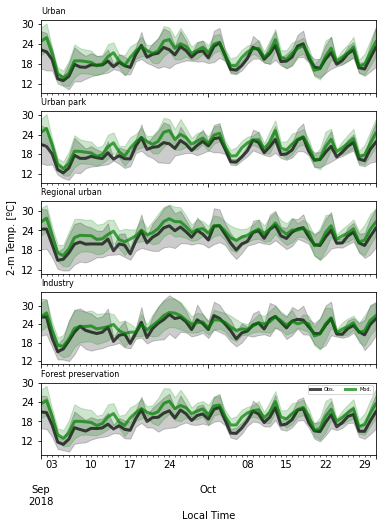

In [44]:
plot_type(met, alpha=0.2, para='tc', ylabel='2-m Temp. [ºC]', station_types=station_types,
         n_yticks = 4, filename='temp_cetesb', path='../4_Draft_Report/Dissertation/fig/')

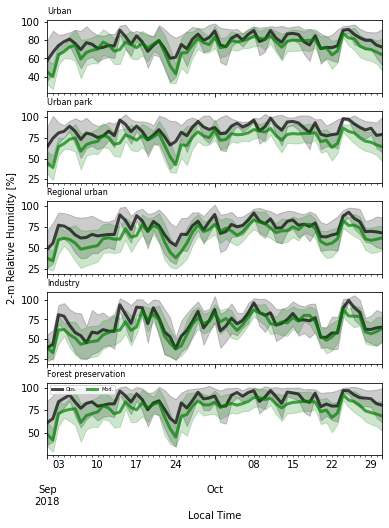

In [45]:
plot_type(met, alpha=0.2, para='rh', ylabel='2-m Relative Humidity [%]', station_types=station_types,
         n_yticks = 4, filename='rh_cetesb', path='../4_Draft_Report/Dissertation/fig/')

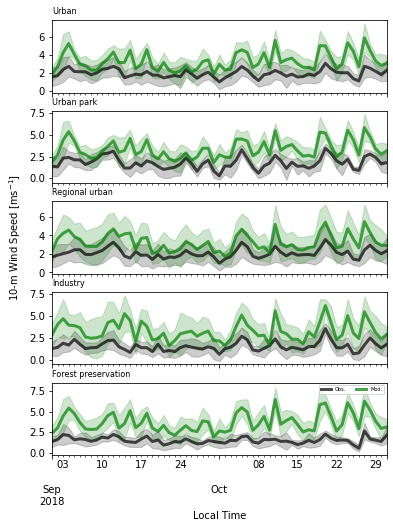

In [46]:
plot_type(met, alpha=0.2, para='ws', ylabel='10-m Wind Speed [ms$^{-1}$] \n', station_types=station_types,
         n_yticks = 4, filename='ws_cetesb', path='../4_Draft_Report/Dissertation/fig/')

## Statistical evaluation

In [42]:
stats_df1 = ms.met_stats(met,mets=['tc', 'rh','ws','wd']).round(2)
stats_df1

,n,MB,MAGE,RMSE,IOA,r,Mm,Om,Msd,Osd
tc,39966,1.31,1.93,2.53,0.92,0.89,21.97,20.66,4.30,4.67
rh,38538,-7.33,11.07,14.36,0.84,0.77,69.42,76.76,17.73,18.47
ws,46920,1.38,1.71,2.13,0.52,0.40,3.32,1.94,1.69,1.13
wd,44312,-20.93,50.54,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [43]:
print(stats_df1.to_latex(caption='Statistical results for meteorological parameters for Sep-Oct 2018 (all stations)',
                            label='tab:stats_all'),
      file=open('../4_Draft_Report/Dissertation/table/stats_all.tex','w'))

In [40]:
stats_type = {}
sta_df = pd.DataFrame()
for i in station_types:
    stats_type[i] = (ms.met_stats(met[met.type.isin([i])],mets=['tc','rh','ws','wd']))
    stats_type[i]['type'] = (i)
    df = stats_type[i]
    sta_df = pd.concat([sta_df,df]).round(2)
sta_df

,n,MB,MAGE,RMSE,IOA,r,Mm,Om,Msd,Osd,type
tc,13526,1.33,1.83,2.41,0.91,0.88,20.96,19.63,3.98,4.09,Urban
rh,13517,-6.92,10.36,13.56,0.82,0.74,71.88,78.79,16.31,15.78,Urban
ws,19450,1.38,1.66,2.03,0.49,0.35,3.32,1.94,1.48,1.05,Urban
wd,18406,-19.20,44.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urban
tc,1415,1.49,1.87,2.48,0.91,0.88,20.42,18.94,4.01,4.09,Urban park
rh,1415,-10.03,12.25,15.35,0.79,0.74,74.04,84.07,15.93,16.20,Urban park
ws,1428,1.58,1.72,2.08,0.52,0.47,3.39,1.82,1.48,1.06,Urban park
wd,1263,-10.26,32.68,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Urban park
tc,19058,1.28,1.98,2.59,0.92,0.88,22.89,21.61,4.26,4.73,Regional urban
rh,17639,-7.55,11.43,14.71,0.84,0.77,66.53,74.08,17.96,19.14,Regional urban


In [41]:
print(sta_df.to_latex(caption='Statistical results for meteorological parameters for Sep-Oct 2018 by type',
                            label='tab:stats_all_type'),
      file=open('../4_Draft_Report/Dissertation/table/stats_all_type.tex','w'))

In [37]:
para = ['tc','rh','ws']
df_1 = pd.DataFrame(index=['t-statistic', 't-critical'])

for p in para:
    df_1[p] = ms.r_pearson_sig(n=stats_df1.loc[p,'n'],
                             r=stats_df1.loc[p,'r'],
                             deg_free=stats_df1.loc[p,'n']-2,
                             alpha=0.05)
    
df_1.round(2)
for p in para:
    df_1.loc['n',p] = stats_df1.loc[p,'n']
    
df_1 = df_1.rename(columns={'tc':'Temp.','rh':'Rel. Hum.', 'ws':'W. Speed'})
df_1.round(2)

Significant linear relationship
Significant linear relationship
Significant linear relationship


,Temp.,Rel. Hum.,W. Speed
t-statistic,390.21,236.90,94.53
t-critical,1.96,1.96,1.96
n,39966.00,38538.00,46920.00


In [38]:
print(df_1.round(2).to_latex(caption='Correlation t-test values by meteorological parameter for Sep-Oct 2018(all stations)',
                            label='tab: r_sign_met_all'),
      file=open('../4_Draft_Report/Dissertation/table/r_sign_met_all.tex','w'))

In [231]:
df_2 = pd.DataFrame(index=['r (lower)', 'r (upper)'])
for p in para:
    df_2[p] = ms.r_pearson_confidence_interval(n=stats_df1.loc[p,'n'], r=stats_df1.loc[p,'r'], alpha=0.05)
df_2.round(2)

,tc,rh,ws
r (lower),0.89,0.77,0.39
r (upper),0.89,0.77,0.41


In [232]:
pd.merge(df_1,df_2, left_index=True, right_index=True, how='outer', on=['tc','rh','ws']).round(2)

,tc,rh,ws
n,39966.00,38538.00,46920.00
r (lower),0.89,0.77,0.39
r (upper),0.89,0.77,0.41
t_cal,390.21,236.90,94.53
t_cri,1.96,1.96,1.96
